# LMing-Rules baseline
* Using language modeling.
* Using rules, extracted from the training data.

### Sign in
* To get the data.

In [ ]:
%%capture
!pip install aicrowd-cli
%load_ext aicrowd.magic

In [2]:
%aicrowd login

Please login here: https://api.aicrowd.com/auth/ZRK_SW7MLRKWe-kcH8erAnLc3_CSYNb2He_hcLv9HdU
API Key valid
Gitlab access token valid
Saved details successfully!


In [3]:
!rm -rf data
!mkdir data
%aicrowd ds dl -c htrec-2022 -o data

test.csv:   0%|          | 0.00/45.5k [00:00<?, ?B/s]

train.csv:   0%|          | 0.00/395k [00:00<?, ?B/s]

In [ ]:
%%capture
!pip install pywer
import pywer
import pandas as pd
import numpy as np
import os

In [12]:
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")
print(f"{train.shape[0]} train and {test.shape[0]} instances"); train.sample()

1875 train and 338 instances


HUMAN_TRANSCRIPTION  \
246  οιονει και την υλην την κοσμουσαν και αυτην   

                          SYSTEM_TRANSCRIPTION  CENTURY  \
246  διόν εικαὶ τὴν χην την κοσμουσαν και αυτη       11   

                                            IMAGE_PATH  TEXT_LINE_NUM  
246  9 Bodleian-Library-MS-Barocci-102_00165_fol-79...              8

### LMing
Using the human-transcribed data to train a statistical character language model.

In [15]:
!git clone https://github.com/ipavlopoulos/lm.git
from lm.markov.models import LM
lm = LM(gram="CHAR").train(train.HUMAN_TRANSCRIPTION.sum()); #cslm.generate_text()
lm.generate_text()

'ἐγγινομενου σρς ἐχθρούς. Εἰ πάντας φιλοπαίγμονα των αὐτῷ, ὡς τῶν λόγῳἔστ᾽, ἐπεὶ νεκρόν· οὐκ ἴσχυσαν ἅπαντός ὀνόματος και αλλωπισμου πόδακαί ὑπό τόν Θεόνὄντα δυναστενόν δέ μοι το αιδοτριβενταυθα μὲν περιεργοῖς, οὓς ἔκτειν᾽ ἀπεικαὶ τύχας σριαςυποθεν ην παρ᾽ οὐδὲν τῶν φράσονται. Τουτέστι, προσεται, καὶ ὑμεῖς πῶς λέβητα ὑποκαιόμενον τό δέξασθαι δύ᾽ ἢ τῆς ἐργάσεται εφοβουαφαιρεσεως πότεπρουθέμην βασιλειαν εμε μιμουμένῃδεδωκοτας ἕλκει· εἶτ᾽ ἀνὰ λειμῶναΧορεύσω και σάρκα κατὰ τοῦ παλαιαὶ Πριαμιδῶν και ουκ ανποτε πέλαβερᾶς και εναντιας του γλωττηςΒακχε,νυκτερηθήσοντα ποιησεν Ἰλιάδ᾽ ἄν τι;δεινόν μ᾽ ἀπειλε Σαοὺλ, καὶ τοῦ ΝαυῆἸησοῦς ἔνεστανττω και προς και παντας ἐλάβοι πλησας ὧν σε ἔκβαλεῖς κόρησεμνον, καθως εἰς τόν σ᾽ ἀνθεμώδεις, ἤνεγκαναὐτὸς ὑμὶν ἐξ Αἰγύπτου και το ποιος και εκαστον αὐτοῖσι τραποίμην προσθοῦ. Εὐφραίνειν ει γαρ ετι τα ιματια υμωντου φανες ησπαζοντες ολην αυτάὁ Ξανθίαν, βοήθησομένην, καὶ σὺ, Κε.Οὐδὲν μακάριος Δαβὶδ, πρόσθε ον φίλταται· ἐγὼπάλαινα μαθηται· ἐγὼμόνος ἄκανθανάτῳ οὐκ

### Frequently mistaken tokens 

In [13]:
LEX = train.HUMAN_TRANSCRIPTION.sum().split()

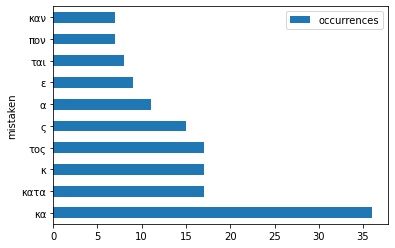

In [18]:
from collections import Counter
broken_words = [w for w in train.SYSTEM_TRANSCRIPTION.sum().split() if w not in set(LEX)]
x,y = zip(*Counter(broken_words).most_common(10))
pd.DataFrame({"mistaken":x, "occurrences":y}).plot.barh(x="mistaken");

Picking one, one that can be fixed without much ambiguity.

In [19]:
train[train.SYSTEM_TRANSCRIPTION.str.contains(" ς ")].sample(2)

HUMAN_TRANSCRIPTION  \
595   μηρ δ᾽ ἐν οἴκοις· ἣν σὺ μὴ δείσῃς ποθ᾽ ὡς   
1156         ως· ὡς αὐτοῦ ὄντος τοῦ Χῦ και ῥήμα   

                    SYSTEM_TRANSCRIPTION  CENTURY  \
595      ξυ ρομι ς ὡς υτῦ δήσεινταρχας γ       16   
1156  ως ω ς αὐτοῦ ον πος τοῦ χυ καιρήε,       15   

                                             IMAGE_PATH  TEXT_LINE_NUM  
595   44 Bodleian-Library-MS-Barocci-66_00318_fol-15...              7  
1156  77 Bodleian-Library-MS-Barocci-59_00082_fol-45...              7

### The method
Exploring the mistakes, two are the easier fixes: merge with the previous word (i.e., this is a final character, which makes sense) or delete. To pick out of the two, we ask the LM.

In [22]:
def lmr(text, word=" ς ", replacements=["ς ", " "], lm=lm):
    scores = []
    for the_candidate in replacements:
        scores.append(lm.cross_entropy(text.replace(word, the_candidate)))
    text_out = text.replace(word, replacements[scores.index(min(scores))])
    return text_out
    
lmr("ως ω ς αὐτοῦ ον πος τοῦ χυ καιρήε,")

'ως ως αὐτοῦ ον πος τοῦ χυ καιρήε,'

### Predict and submit

In [23]:
R1 = test.SYSTEM_TRANSCRIPTION.apply(lmr)

In [27]:
submission = pd.DataFrame(zip(test.IMAGE_PATH, R1), columns=["ImageID", "Transcriptions"])
submission.sample()

ImageID             Transcriptions
2  66 Bodleian-Library-MS-Barocci-127_00136_fol-66v  συ σ κατεχισωμε ἐπιτελωτι

In [25]:
submission.to_csv("submission.csv", index=False)

In [26]:
%aicrowd submission create -c htrec-2022 -f submission.csv

Output()

╭─────────────────────────╮                                     
                                    │ Successfully submitted! │                                     
                                    ╰─────────────────────────╯

                                          Important links                                           
┌──────────────────┬───────────────────────────────────────────────────────────────────────────────┐
│  This submission │ https://www.aicrowd.com/challenges/htrec-2022/submissions/187737              │
│                  │                                                                               │
│  All submissions │ https://www.aicrowd.com/challenges/htrec-2022/submissions?my_submissions=true │
│                  │                                                                               │
│      Leaderboard │ https://www.aicrowd.com/challenges/htrec-2022/leaderboards                    │
│                  │                                                                               │
│ Discussion forum │ https://discourse.aicrowd.com/c/htrec-2022                                    │
│                  │                                                                               │
│   Challenge page │ https://www.aicrowd.com/challenges/htrec-2022                                 │
└──────────────────┴───────────────────────────────────────────────────────────────────────────────┘

{'submission_id': 187737, 'created_at': '2022-06-06T11:41:37.986Z'}
